In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Provide the correct path to your dataset in Google Drive
file_path = '/content/drive/My Drive/ml datasets'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
original_data_path = "/content/drive/My Drive/ml datasets/PhiUSIIL_Phishing_URL_Dataset.csv"
df_original = pd.read_csv(original_data_path)

new_data_path = "/content/drive/My Drive/ml datasets/phishing_site_urls.csv"
df_new = pd.read_csv(new_data_path)

# Standardize column names
df_new.rename(columns={'Label': 'label'}, inplace=True)  # Ensure consistency
df_original.rename(columns={'Label': 'label'}, inplace=True)  # If needed

# Convert "good" to 0 (Legitimate) and "bad" to 1 (Phishing) in the new dataset
df_new['label'] = df_new['label'].map({'good': 0, 'bad': 1})

# Remove any rows with missing labels
df_new.dropna(subset=['label'], inplace=True)

In [ ]:
# Print first 5 records of each dataset
print("First 5 records of Original Dataset:")
print(df_original.head())

print("\nFirst 5 records of New Dataset:")
print(df_new.head())

First 5 records of Original Dataset:
     FILENAME                                 URL  URLLength  \
0  521848.txt    https://www.southbankmosaics.com         31   
1   31372.txt            https://www.uni-mainz.de         23   
2  597387.txt      https://www.voicefmradio.co.uk         29   
3  554095.txt         https://www.sfnmjournal.com         26   
4  151578.txt  https://www.rewildingargentina.org         33   

                       Domain  DomainLength  IsDomainIP  TLD  \
0    www.southbankmosaics.com            24           0  com   
1            www.uni-mainz.de            16           0   de   
2      www.voicefmradio.co.uk            22           0   uk   
3         www.sfnmjournal.com            19           0  com   
4  www.rewildingargentina.org            26           0  org   

   URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  ...  Pay  \
0               100.0              1.000000           0.522907  ...    0   
1               100.0              0.6666

In [ ]:
# Count phishing (1) and legitimate (0) URLs for Original Dataset
print("\nOriginal Dataset Class Distribution:")
print(df_original['label'].value_counts())

print("\nOriginal Dataset Class Distribution in Percentage:")
print(df_original['label'].value_counts(normalize=True) * 100)

# Count phishing (1) and legitimate (0) URLs for New Dataset
print("\nNew Dataset Class Distribution:")
print(df_new['label'].value_counts())

print("\nNew Dataset Class Distribution in Percentage:")
print(df_new['label'].value_counts(normalize=True) * 100)



Original Dataset Class Distribution:
label
1    134850
0    100945
Name: count, dtype: int64

Original Dataset Class Distribution in Percentage:
label
1    57.189508
0    42.810492
Name: proportion, dtype: float64

New Dataset Class Distribution:
label
0    392924
1    156422
Name: count, dtype: int64

New Dataset Class Distribution in Percentage:
label
0    71.525778
1    28.474222
Name: proportion, dtype: float64


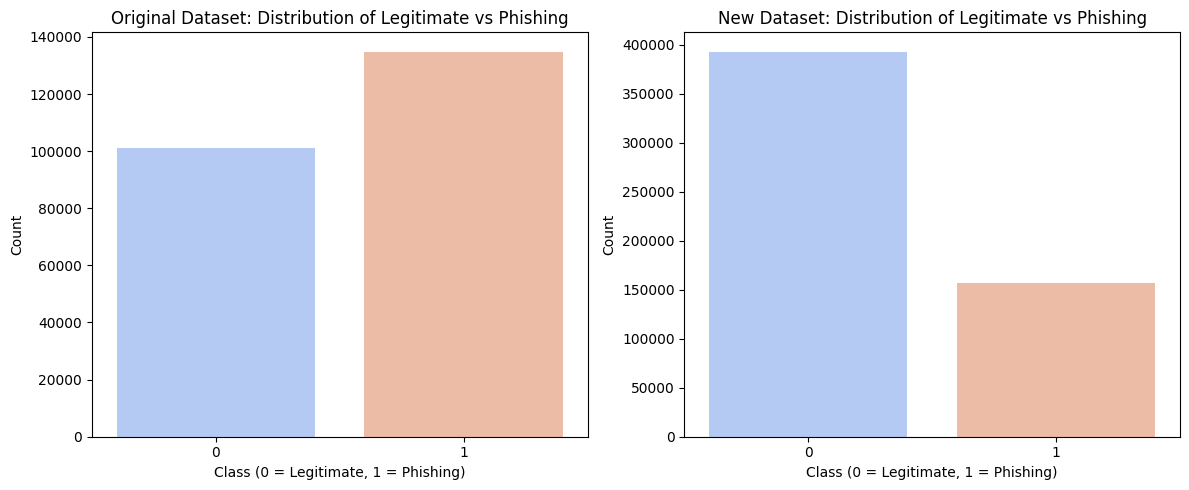

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Original Dataset
sns.countplot(x=df_original["label"], hue=df_original["label"], palette="coolwarm", legend=False, ax=axes[0])
axes[0].set_title("Original Dataset: Distribution of Legitimate vs Phishing")
axes[0].set_xlabel("Class (0 = Legitimate, 1 = Phishing)")
axes[0].set_ylabel("Count")

# Plot for New Dataset
sns.countplot(x=df_new["label"], hue=df_new["label"], palette="coolwarm", legend=False, ax=axes[1])
axes[1].set_title("New Dataset: Distribution of Legitimate vs Phishing")
axes[1].set_xlabel("Class (0 = Legitimate, 1 = Phishing)")
axes[1].set_ylabel("Count")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


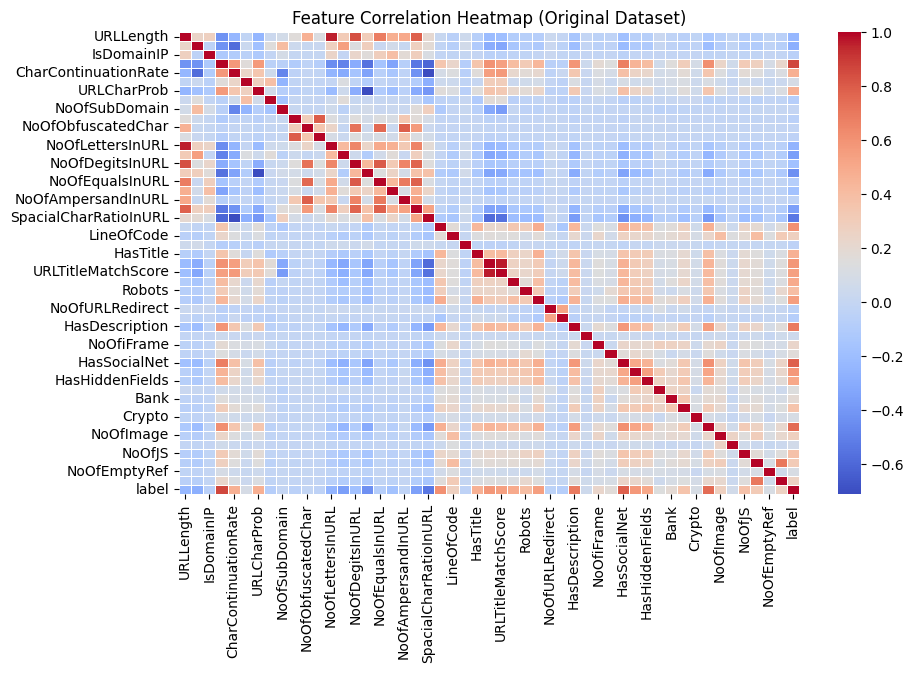

In [ ]:
# Select only numeric columns from the original dataset
numeric_df_original = df_original.select_dtypes(include=[np.number])

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df_original.corr(), cmap="coolwarm", annot=False, linewidths=0.5)

# Set title
plt.title("Feature Correlation Heatmap (Original Dataset)")
plt.show()

In [ ]:
def extract_features(url):
    """Extracts numerical and text-based features from a given URL."""
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    tld = domain.split('.')[-1] if '.' in domain else ""

    return {
        'URL': url,
        'Domain': domain,
        'TLD': tld,
        'URLLength': len(url),
        'DomainLength': len(domain),
        'TLDLength': len(tld),
        'IsHTTPS': 1 if url.startswith('https') else 0,
        'NoOfSubDomain': domain.count('.') - 1,
        'HasObfuscation': 1 if '%' in url or '0x' in url else 0,
        'NoOfObfuscatedChar': sum(1 for c in url if c in "%0x"),
        'ObfuscationRatio': sum(1 for c in url if c in "%0x") / len(url) if len(url) > 0 else 0,
        'NoOfLettersInURL': sum(c.isalpha() for c in url),
        'LetterRatioInURL': sum(c.isalpha() for c in url) / len(url) if len(url) > 0 else 0,
        'NoOfDigitsInURL': sum(c.isdigit() for c in url),
        'DigitRatioInURL': sum(c.isdigit() for c in url) / len(url) if len(url) > 0 else 0,
        'NoOfEqualsInURL': url.count('='),
        'NoOfQMarkInURL': url.count('?'),
        'NoOfAmpersandInURL': url.count('&'),
        'NoOfOtherSpecialCharsInURL': sum(url.count(c) for c in ['$', '#', '!', '*']),
        'SpecialCharRatioInURL': sum(url.count(c) for c in ['$', '#', '!', '*']) / len(url) if len(url) > 0 else 0,
        'IsDomainIP': 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain) else 0,
        'HasAtSymbol': 1 if '@' in url else 0,
        'HasMultipleSlashes': 1 if url.count('/') > 5 else 0,
        'HasHyphenInDomain': 1 if '-' in domain else 0,
        'IsShortDomain': 1 if len(domain) < 10 else 0,
        'HasLoginKeyword': 1 if any(kw in url.lower() for kw in ['login', 'secure', 'verify']) else 0,
        'HasSuspiciousWords': 1 if any(kw in url.lower() for kw in ['free', 'gift', 'win', 'prize']) else 0,
        'Bank': 1 if any(kw in url.lower() for kw in ['bank', 'paypal', 'secure']) else 0,
        'Pay': 1 if 'pay' in url.lower() else 0,
        'Crypto': 1 if any(kw in url.lower() for kw in ['bitcoin', 'crypto', 'blockchain']) else 0
    }

# Apply feature extraction to df_new
df_new_features = pd.DataFrame(df_new['URL'].apply(extract_features).tolist())

# Add label column back
df_new_features['label'] = df_new['label']


In [ ]:
# Ensure both datasets have the same feature columns
common_columns = list(set(df_original.columns) & set(df_new_features.columns))
df_original = df_original[common_columns]
df_new_features = df_new_features[common_columns]

# Merge datasets
df_combined = pd.concat([df_original, df_new_features], ignore_index=True)

# Remove duplicate URLs
df_combined.drop_duplicates(subset=['URL'], keep='first', inplace=True)

# Shuffle dataset
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Save final dataset
df_combined.to_csv("combined_phishing_dataset.csv", index=False)

print(f"\n Final Combined Dataset Shape: {df_combined.shape}")
print(df_combined.head())


✅ Final Combined Dataset Shape: (742565, 22)
                                                 URL TLD  TLDLength  \
0     artfact.com/artist/brewster-john-jr-5u6g2s9nte              0   
1                     nme.com/artists/gerald-wiggins              0   
2  faqs.org/copyright/its-too-late-now-to-say-you...              0   
3                             https://www.sbp.org.pk  pk          2   
4              addons.mozilla.org/firefox/addon/5519              0   

   HasObfuscation  NoOfLettersInURL  Pay  NoOfEqualsInURL  label  \
0               0                36    0                0      0   
1               0                26    0                0      0   
2               0                62    0                0      0   
3               0                 7    1                0      1   
4               0                28    0                0      0   

   NoOfSubDomain          Domain  ...  LetterRatioInURL  IsDomainIP  \
0             -1                  ...          

In [ ]:
import shutil
import os

# Define the path to save in Google Drive
drive_folder = "/content/drive/MyDrive/ml_datasets"  # Change this if needed

# Create directory if it doesn't exist
os.makedirs(drive_folder, exist_ok=True)

# Ensure the dataset exists before copying
dataset_path = "combined_phishing_dataset.csv"

if os.path.exists(dataset_path):
    shutil.copy(dataset_path, f"{drive_folder}/combined_phishing_dataset.csv")  # Use copy instead of move
    print(f"Merged dataset saved successfully in: {drive_folder}/combined_phishing_dataset.csv")
else:
    print(f"File not found: {dataset_path}. Ensure it was created correctly before saving.")


✅ Merged dataset saved successfully in: /content/drive/MyDrive/ml_datasets/combined_phishing_dataset.csv


In [ ]:
# Define features
num_features = [col for col in df_combined.columns if col not in ['URL', 'Domain', 'TLD', 'label']]
text_feature = 'URL'

In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_num = scaler.fit_transform(df_combined[num_features])

In [ ]:
# Tokenize URLs
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(df_combined[text_feature])
X_text = tokenizer.texts_to_sequences(df_combined[text_feature])
X_text = tf.keras.preprocessing.sequence.pad_sequences(X_text, maxlen=100)

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
y = df_combined['label'].values
X_num_train, X_num_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_num, X_text, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# MLP for Numerical Features
num_input = Input(shape=(X_num_train.shape[1],))
x_num = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(num_input)  # Added L2 Regularization
x_num = BatchNormalization()(x_num)
x_num = Dropout(0.4)(x_num)  # Increased Dropout
x_num = Dense(64, activation='relu')(x_num)
x_num = Dropout(0.3)(x_num)

In [ ]:
# CNN for URL Text
text_input = Input(shape=(100,))
embedding = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=50, input_length=100)(text_input)
x_text = Conv1D(64, kernel_size=5, activation='relu')(embedding)  # Reduced Layer Size
x_text = MaxPooling1D(pool_size=2)(x_text)
x_text = Conv1D(32, kernel_size=3, activation='relu')(x_text)  # Reduced Layer Size
x_text = GlobalMaxPooling1D()(x_text)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Combine MLP + CNN
merged = Concatenate()([x_num, x_text])
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(merged)  # Added L2 Regularization
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

In [ ]:
# Compile Model
model = Model(inputs=[num_input, text_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# -------------------- Fix Overfitting: Limit Training Epochs --------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  # Reduced patience

# -------------------- Train the Model --------------------
history = model.fit(
    [X_num_train, X_text_train], y_train,
    validation_data=([X_num_test, X_text_test], y_test),
    epochs=10,  # Limited to 10 (Overfitting started at Epoch 9)
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]  # Stops early if overfitting occurs
)

Epoch 1/10
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 184s 20ms/step - accuracy: 0.9242 - loss: 0.2421 - val_accuracy: 0.9691 - val_loss: 0.0935
Epoch 2/10
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 198s 19ms/step - accuracy: 0.9671 - loss: 0.1044 - val_accuracy: 0.9615 - val_loss: 0.1112
Epoch 3/10
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 181s 19ms/step - accuracy: 0.9722 - loss: 0.0880 - val_accuracy: 0.9747 - val_loss: 0.0785
Epoch 4/10
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 208s 20ms/step - accuracy: 0.9745 - loss: 0.0819 - val_accuracy: 0.9750 - val_loss: 0.0763
Epoch 5/10
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 195s 19ms/step - accuracy: 0.9759 - loss: 0.0776 - val_accuracy: 0.9775 - val_loss: 0.0691
Epoch 6/10
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 181s 20ms/step - accuracy: 0.9776 - loss: 0.0727 - val_accuracy: 0.9779 - val_loss: 0.0684
Epoch 7/10
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 185s 20ms/step - accuracy: 0.9784 - loss: 0.0698 - val_accuracy: 0.9782 - val_loss: 0.0677
Epoch 8/10
9283/9283 ━━━━━━━━━━━━━━━━━━━━ 185s 20ms/step - accuracy: 

In [ ]:
import joblib
import shutil
from google.colab import drive

# Define Google Drive path
drive_folder = "/content/drive/MyDrive/ml_datasets"
os.makedirs(drive_folder, exist_ok=True)

# Save trained model, tokenizer, and scaler
model.save(f"{drive_folder}/phishing_detection_model.h5")
joblib.dump(tokenizer, f"{drive_folder}/tokenizer.pkl")
joblib.dump(scaler, f"{drive_folder}/scaler.pkl")


['/content/drive/MyDrive/ml_datasets/scaler.pkl']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test data
y_pred_prob = model.predict([X_num_test, X_text_test])
y_pred = (y_pred_prob > 0.5).astype(int)

# Print structured metrics report
print("\n Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, digits=4))

4642/4642 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step

 Model Performance:
Accuracy: 0.9782
              precision    recall  f1-score   support

           0     0.9839    0.9833    0.9836     98683
           1     0.9670    0.9681    0.9675     49830

    accuracy                         0.9782    148513
   macro avg     0.9754    0.9757    0.9756    148513
weighted avg     0.9782    0.9782    0.9782    148513



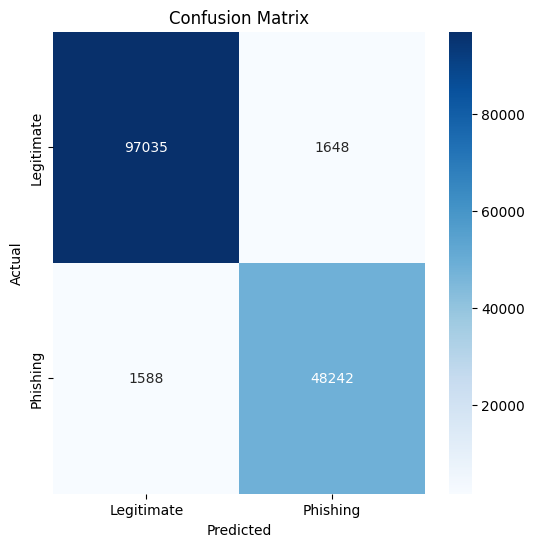

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Legitimate", "Phishing"],
            yticklabels=["Legitimate", "Phishing"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

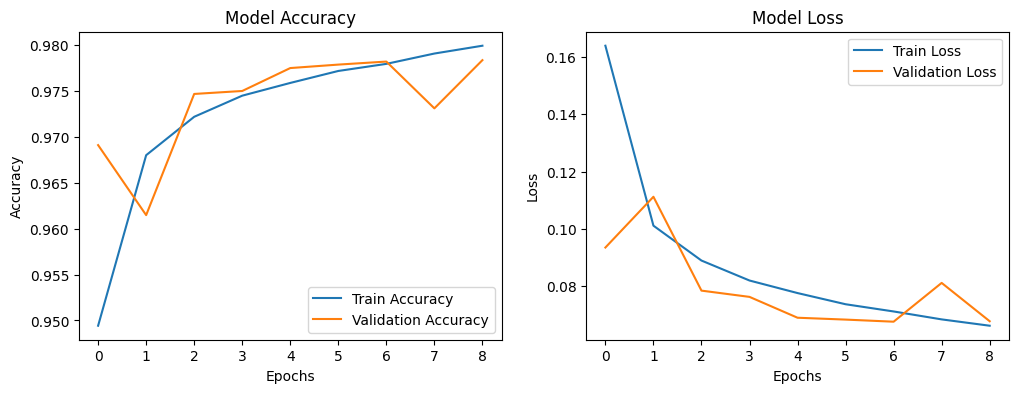

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Path where the trained model and tools are stored in Google Drive
MODEL_PATH = "/content/drive/MyDrive/ml_datasets"

# Load trained model
model = tf.keras.models.load_model(f"{MODEL_PATH}/phishing_detection_model.h5")

# Load tokenizer & scaler
tokenizer = joblib.load(f"{MODEL_PATH}/tokenizer.pkl")
scaler = joblib.load(f"{MODEL_PATH}/scaler.pkl")

print("Model, tokenizer, and scaler loaded successfully from Google Drive!")


✅Model, tokenizer, and scaler loaded successfully from Google Drive!


In [ ]:
def extract_features(url):
    """Extracts only the features used in model training."""
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    tld = domain.split('.')[-1] if '.' in domain else ""

    # Extract only the required features (these must match the training features)
    features = {
        'TLDLength': len(tld),
        'HasObfuscation': 1 if '%' in url or '0x' in url else 0,
        'NoOfLettersInURL': sum(c.isalpha() for c in url),
        'Pay': 1 if 'pay' in url.lower() else 0,
        'NoOfEqualsInURL': url.count('='),
        'NoOfSubDomain': domain.count('.') - 1,
        'URLLength': len(url),
        'NoOfAmpersandInURL': url.count('&'),
        'LetterRatioInURL': sum(c.isalpha() for c in url) / len(url) if len(url) > 0 else 0,
        'IsDomainIP': 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain) else 0,
        'NoOfQMarkInURL': url.count('?'),
        'ObfuscationRatio': sum(1 for c in url if c in "%0x") / len(url) if len(url) > 0 else 0,
        'DomainLength': len(domain),
        'Crypto': 1 if any(kw in url.lower() for kw in ['bitcoin', 'crypto', 'blockchain']) else 0,
        'NoOfOtherSpecialCharsInURL': sum(url.count(c) for c in ['$', '#', '!', '*']),
        'Bank': 1 if any(kw in url.lower() for kw in ['bank', 'paypal', 'secure']) else 0,
        'IsHTTPS': 1 if url.startswith('https') else 0,
        'NoOfObfuscatedChar': sum(1 for c in url if c in "%0x"),
    }

    # Convert to DataFrame and ensure correct column order
    feature_df = pd.DataFrame([features])

    # Ensure feature order matches training data
    feature_df = feature_df[scaler.feature_names_in_]

    return feature_df, url

def predict_url(url):
    """Predicts whether a given URL is Phishing (1) or Legitimate (0)."""

    # Extract features
    unseen_data, raw_url = extract_features(url)

    # Scale numerical features
    num_features = scaler.transform(unseen_data)

    # Process text features (URL)
    text_sequences = tokenizer.texts_to_sequences([url])
    text_padded = pad_sequences(text_sequences, maxlen=100)

    # Predict
    prediction = model.predict([num_features, text_padded])[0, 0]
    is_phishing = int(prediction > 0.5)

    # Print Result
    print(f"\n URL: {raw_url} --> {'Phishing 🚨' if is_phishing else 'Legitimate ✅'}")

    return is_phishing

# -------------------- Test on Real-World URLs --------------------
test_urls = ["https://flipkart.com/"]

for url in test_urls:
    predict_url(url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

 URL: https://flipkart.com/ --> Legitimate ✅


In [ ]:
print("Features used during training:", scaler.feature_names_in_)


Features used during training: ['TLDLength' 'HasObfuscation' 'NoOfLettersInURL' 'Pay' 'NoOfEqualsInURL'
 'NoOfSubDomain' 'URLLength' 'NoOfAmpersandInURL' 'LetterRatioInURL'
 'IsDomainIP' 'NoOfQMarkInURL' 'ObfuscationRatio' 'DomainLength' 'Crypto'
 'NoOfOtherSpecialCharsInURL' 'Bank' 'IsHTTPS' 'NoOfObfuscatedChar']


In [3]:
pip install flask pyngrok

In [4]:
!ngrok authtoken '2uP4VbpOvvMxA47BPcN7ghQnfbv_rUQMKFnHfpjQRFdPayuS'

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [8]:
import os
import threading
from flask import Flask, request, render_template_string, jsonify
import tensorflow as tf
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from urllib.parse import urlparse
import re
from pyngrok import ngrok  # Manually create ngrok tunnel

# Initialize Flask App
app = Flask(__name__)

# Load Trained Model & Preprocessing Tools
MODEL_PATH = "/content/drive/MyDrive/ml_datasets"
model = tf.keras.models.load_model(f"{MODEL_PATH}/phishing_detection_model.h5", compile=False)
tokenizer = joblib.load(f"{MODEL_PATH}/tokenizer.pkl")
scaler = joblib.load(f"{MODEL_PATH}/scaler.pkl")
print("Model and preprocessing tools loaded successfully!")

# Feature Extraction Function
def extract_features(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    tld = domain.split('.')[-1] if '.' in domain else ""

    features = {
        'TLDLength': len(tld),
        'HasObfuscation': 1 if '%' in url or '0x' in url else 0,
        'NoOfLettersInURL': sum(c.isalpha() for c in url),
        'Pay': 1 if 'pay' in url.lower() else 0,
        'NoOfEqualsInURL': url.count('='),
        'NoOfSubDomain': domain.count('.') - 1,
        'URLLength': len(url),
        'NoOfAmpersandInURL': url.count('&'),
        'LetterRatioInURL': sum(c.isalpha() for c in url) / len(url) if len(url) > 0 else 0,
        'IsDomainIP': 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain) else 0,
        'NoOfQMarkInURL': url.count('?'),
        'ObfuscationRatio': sum(1 for c in url if c in "%0x") / len(url) if len(url) > 0 else 0,
        'DomainLength': len(domain),
        'Crypto': 1 if any(kw in url.lower() for kw in ['bitcoin', 'crypto', 'blockchain']) else 0,
        'NoOfOtherSpecialCharsInURL': sum(url.count(c) for c in ['$', '#', '!', '*']),
        'Bank': 1 if any(kw in url.lower() for kw in ['bank', 'paypal', 'secure']) else 0,
        'IsHTTPS': 1 if url.startswith('https') else 0,
        'NoOfObfuscatedChar': sum(1 for c in url if c in "%0x"),
    }

    feature_df = pd.DataFrame([features])
    feature_df = feature_df[scaler.feature_names_in_]

    return feature_df

# Prediction Function
def predict_url(url):
    features = extract_features(url)
    num_features = scaler.transform(features)
    text_sequences = tokenizer.texts_to_sequences([url])
    text_padded = pad_sequences(text_sequences, maxlen=100)

    prediction = model.predict([num_features, text_padded])[0, 0]
    is_phishing = int(prediction > 0.5)

    return " Phishing" if is_phishing else "Legitimate"

# HTML Web Interface
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Phishing URL Detector - Dark Mode</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background-color: #121212;
            color: #fff;
            display: flex;
            align-items: center;
            justify-content: center;
            height: 100vh;
            width: 100%;
            padding: 20px;
        }

        .container {
            background: linear-gradient(135deg, #1a1a2e, #16213e);
            padding: 50px;
            border-radius: 15px;
            text-align: center;
            box-shadow: 0px 0px 25px rgba(0, 255, 255, 0.3);
            width: 100%;
            max-width: 900px;
            min-height: 400px;
            display: flex;
            flex-direction: column;
            justify-content: center;
            align-items: center;
            overflow: hidden;
        }

        .input-group {
            width: 100%;
            max-width: 800px;
            display: flex;
            justify-content: center;
        }

        .input-group input {
            flex: 1;
            background-color: #222;
            color: #fff;
            border: 1px solid #00d4ff;
            padding: 15px;
            font-size: 1.1rem;
        }

        .btn {
            background-color: #00d4ff;
            border: none;
            color: #121212;
            font-weight: bold;
            transition: 0.3s;
            padding: 15px 20px;
            font-size: 1.1rem;
        }

        .btn:hover {
            background-color: #009bbf;
        }

        .alert {
            font-size: 1.2rem;
            display: none;
            width: 100%;
            max-width: 750px;
            word-wrap: break-word;
            overflow-wrap: break-word;
            white-space: normal;
        }

        .alert a {
            font-weight: bold;
            color: #0000FF;
            word-wrap: break-word;
        }

        .alert-success strong {
            color: green;
            font-weight: bold;
        }

        .alert-danger strong {
            color: red;
            font-weight: bold;
        }

    </style>
</head>
<body>
    <div class="container">
        <div class="jumbotron rounded-3">
            <h1 class="display-5 fw-bold"> Phishing URL Detector</h1>
            <p class="lead">Enter a URL below to check if it's safe.</p>
            <form id="urlForm" class="mt-3">
                <div class="input-group">
                    <input type="text" id="urlInput" name="url" class="form-control" placeholder="Enter a URL..." required>
                    <button type="submit" class="btn">Check</button>
                </div>
            </form>
            <div id="alert-container" class="mt-4">
                <div id="alert-success" class="alert alert-success" role="alert">
                    <p id="safe-message"></p>
                </div>
                <div id="alert-danger" class="alert alert-danger" role="alert">
                    <p id="phishing-message"></p>
                </div>
            </div>
        </div>
    </div>

    <script>
        document.getElementById("urlForm").addEventListener("submit", function (event) {
            event.preventDefault();
            let url = document.getElementById("urlInput").value.trim();
            let safeAlert = document.getElementById("alert-success");
            let phishingAlert = document.getElementById("alert-danger");
            let safeMessage = document.getElementById("safe-message");
            let phishingMessage = document.getElementById("phishing-message");

            fetch("/", {
                method: "POST",
                headers: { "Content-Type": "application/x-www-form-urlencoded" },
                body: new URLSearchParams({ "url": url })
            })
            .then(response => response.json())
            .then(data => {
                let formattedUrl = `<a href="${url}" target="_blank">${url}</a><br><br>`;

                if (data.result === "Legitimate") {
                    safeMessage.innerHTML = `${formattedUrl} <strong>✅ This is a Legitimate url.</strong>`;
                    safeAlert.style.display = "block";
                    phishingAlert.style.display = "none";
                } else {
                    phishingMessage.innerHTML = `${formattedUrl} <strong>❌ Phishing Site Detected!</strong>`;
                    phishingAlert.style.display = "block";
                    safeAlert.style.display = "none";
                }
            })
            .catch(error => console.error("Error:", error));
        });
    </script>
</body>
</html>
"""

# Flask Routes
@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        url_entered = request.form["url"]
        predicted_result = predict_url(url_entered)
        return jsonify({"result": predicted_result})

    return render_template_string(HTML_TEMPLATE)

# Start Flask Server and Open `ngrok` Tunnel
if __name__ == "__main__":
    public_url = ngrok.connect(5001).public_url
    print(f"Public URL: {public_url}")
    app.run(port=5001)


Model and preprocessing tools loaded successfully!
Public URL: https://e47b-34-16-175-48.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 17:38:40] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 17:38:41] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


INFO:werkzeug:127.0.0.1 - - [21/Mar/2025 17:38:44] "POST / HTTP/1.1" 200 -


In [6]:
!pkill -f ngrok

In [9]:
import os
import threading
from flask import Flask, request, render_template_string, jsonify
import tensorflow as tf
import joblib
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from urllib.parse import urlparse
import re
from pyngrok import ngrok

# Initialize Flask App
app = Flask(__name__)

# Load Model & Preprocessing Tools
MODEL_PATH = "/content/drive/MyDrive/ml_datasets"
model = tf.keras.models.load_model(f"{MODEL_PATH}/phishing_detection_model.h5")
tokenizer = joblib.load(f"{MODEL_PATH}/tokenizer.pkl")
scaler = joblib.load(f"{MODEL_PATH}/scaler.pkl")

print("Model and preprocessing tools loaded successfully!")

# Feature Extraction Function
def extract_features(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    tld = domain.split('.')[-1] if '.' in domain else ""

    features = {
        'TLDLength': len(tld),
        'HasObfuscation': 1 if '%' in url or '0x' in url else 0,
        'NoOfLettersInURL': sum(c.isalpha() for c in url),
        'Pay': 1 if 'pay' in url.lower() else 0,
        'NoOfEqualsInURL': url.count('='),
        'NoOfSubDomain': domain.count('.') - 1,
        'URLLength': len(url),
        'NoOfAmpersandInURL': url.count('&'),
        'LetterRatioInURL': sum(c.isalpha() for c in url) / len(url) if len(url) > 0 else 0,
        'IsDomainIP': 1 if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain) else 0,
        'NoOfQMarkInURL': url.count('?'),
        'ObfuscationRatio': sum(1 for c in url if c in "%0x") / len(url) if len(url) > 0 else 0,
        'DomainLength': len(domain),
        'Crypto': 1 if any(kw in url.lower() for kw in ['bitcoin', 'crypto', 'blockchain']) else 0,
        'NoOfOtherSpecialCharsInURL': sum(url.count(c) for c in ['$', '#', '!', '*']),
        'Bank': 1 if any(kw in url.lower() for kw in ['bank', 'paypal', 'secure']) else 0,
        'IsHTTPS': 1 if url.startswith('https') else 0,
        'NoOfObfuscatedChar': sum(1 for c in url if c in "%0x"),
    }

    feature_df = pd.DataFrame([features])
    feature_df = feature_df[scaler.feature_names_in_]
    return feature_df

# Prediction Function
def predict_url(url):
    features = extract_features(url)
    num_features = scaler.transform(features)
    text_sequences = tokenizer.texts_to_sequences([url])
    text_padded = pad_sequences(text_sequences, maxlen=100)

    confidence = model.predict([num_features, text_padded])[0, 0]
    is_phishing = confidence > 0.5
    label = "Phishing" if is_phishing else "Legitimate"

    return label, float(confidence)

# HTML Interface with CSS and JavaScript

HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Phishing URL Detector</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            background-color: #121212;
            color: #fff;
            display: flex;
            align-items: center;
            justify-content: center;
            height: 100vh;
            padding: 20px;
        }
        .container {
            background: linear-gradient(135deg, #1a1a2e, #16213e);
            padding: 50px;
            border-radius: 15px;
            text-align: center;
            box-shadow: 0px 0px 25px rgba(0, 255, 255, 0.3);
            max-width: 600px;
            width: 100%;
        }
        .input-group {
            display: flex;
            gap: 10px;
        }
        .form-control {
            background-color: #222;
            color: #fff;
            border: 1px solid #00d4ff;
        }
        .btn {
            background-color: #00d4ff;
            border: none;
            color: #121212;
            font-weight: bold;
        }
        .alert {
            display: none;
            margin-top: 15px;
            font-weight: bold;
            word-wrap: break-word;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Phishing URL Detector</h1>
        <form id="urlForm" class="input-group">
            <input type="text" id="urlInput" class="form-control" placeholder="Enter URL..." required>
            <button type="submit" class="btn">Check</button>
        </form>
        <div id="result" class="alert"></div>
    </div>

    <script>
        document.getElementById("urlForm").addEventListener("submit", function(event) {
            event.preventDefault();
            let url = document.getElementById("urlInput").value.trim();
            let resultDiv = document.getElementById("result");

            fetch("/", {
                method: "POST",
                headers: { "Content-Type": "application/x-www-form-urlencoded" },
                body: new URLSearchParams({ "url": url })
            })
            .then(response => response.json())
            .then(data => {
                resultDiv.style.display = "block";
                resultDiv.innerHTML = `<strong>URL:</strong> <br> <a href="${url}" target="_blank">${url}</a><br><br>`;
                if (data.result === "Legitimate") {
                    resultDiv.className = "alert alert-success";
                    resultDiv.innerHTML += `✅ This is a Legitimate url. Confidence: ${(data.confidence * 100).toFixed(2)}%`;
                } else {
                    resultDiv.className = "alert alert-danger";
                    resultDiv.innerHTML += `❌ Phishing Site Detected! Confidence: ${(data.confidence * 100).toFixed(2)}%`;
                }
            })
            .catch(error => console.error("Error:", error));
        });
    </script>
</body>
</html>
"""

# Flask Routes
@app.route("/", methods=["GET", "POST"])
def index():
    if request.method == "POST":
        url_entered = request.form["url"].strip()
        predicted_result, confidence = predict_url(url_entered)
        return jsonify({"result": predicted_result, "confidence": confidence})
    return render_template_string(HTML_TEMPLATE)

# Start Flask Server with Ngrok
def run_flask():
    app.run(port=5001, use_reloader=False)

def start_ngrok():
    tunnel = ngrok.connect(5001)
    print(f"Public URL: {tunnel.public_url}")

if __name__ == "__main__":
    threading.Thread(target=run_flask).start()
    start_ngrok()


Model and preprocessing tools loaded successfully!
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit


Public URL: https://bbc2-34-16-175-48.ngrok-free.app
